In [3]:
!pip install split-folders
# Import các thư viện cần thiết
import tensorflow as tf
import os
import splitfolders
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPool2D, GlobalMaxPool2D
from tensorflow.keras import Input
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.models import load_model
import numpy as np
import cv2
from matplotlib import pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

  Using cached split_folders-0.5.1-py3-none-any.whl (8.4 kB)


In [4]:
# Đường dẫn folder dataset ban đầu
path = '/kaggle/input/car-vs-bike-classification-dataset/Car-Bike-Dataset'

In [5]:
splitfolders.ratio(path, output="/kaggle/working/data_splitted",
    seed=1337, ratio=(.8, .1, .1), group_prefix=None, move=False)

Copying files: 4000 files [00:25, 157.58 files/s]


In [6]:
train_path = '/kaggle/working/data_splitted/train'
test_path = '/kaggle/working/data_splitted/test'
val_path = '/kaggle/working/data_splitted/val'

In [7]:
train_gen = ImageDataGenerator(
    rescale = 1./255,
     horizontal_flip=True,
     vertical_flip=False,
     zoom_range=0.2,
     rotation_range=15,
     shear_range=0.2,    
)
val_gen = ImageDataGenerator(rescale = 1./255)
test_gen = ImageDataGenerator(rescale = 1./255)

train_data = train_gen.flow_from_directory(
    train_path,
    target_size = (224, 224),
    batch_size = 32,
)
val_data = val_gen.flow_from_directory(
    val_path,
    target_size = (224, 224),
    batch_size = 32,
    shuffle=False
)
test_data = test_gen.flow_from_directory(
    test_path,
    target_size = (224, 224),
    batch_size = 1,
    shuffle=False
)

Found 3200 images belonging to 2 classes.
Found 400 images belonging to 2 classes.
Found 400 images belonging to 2 classes.


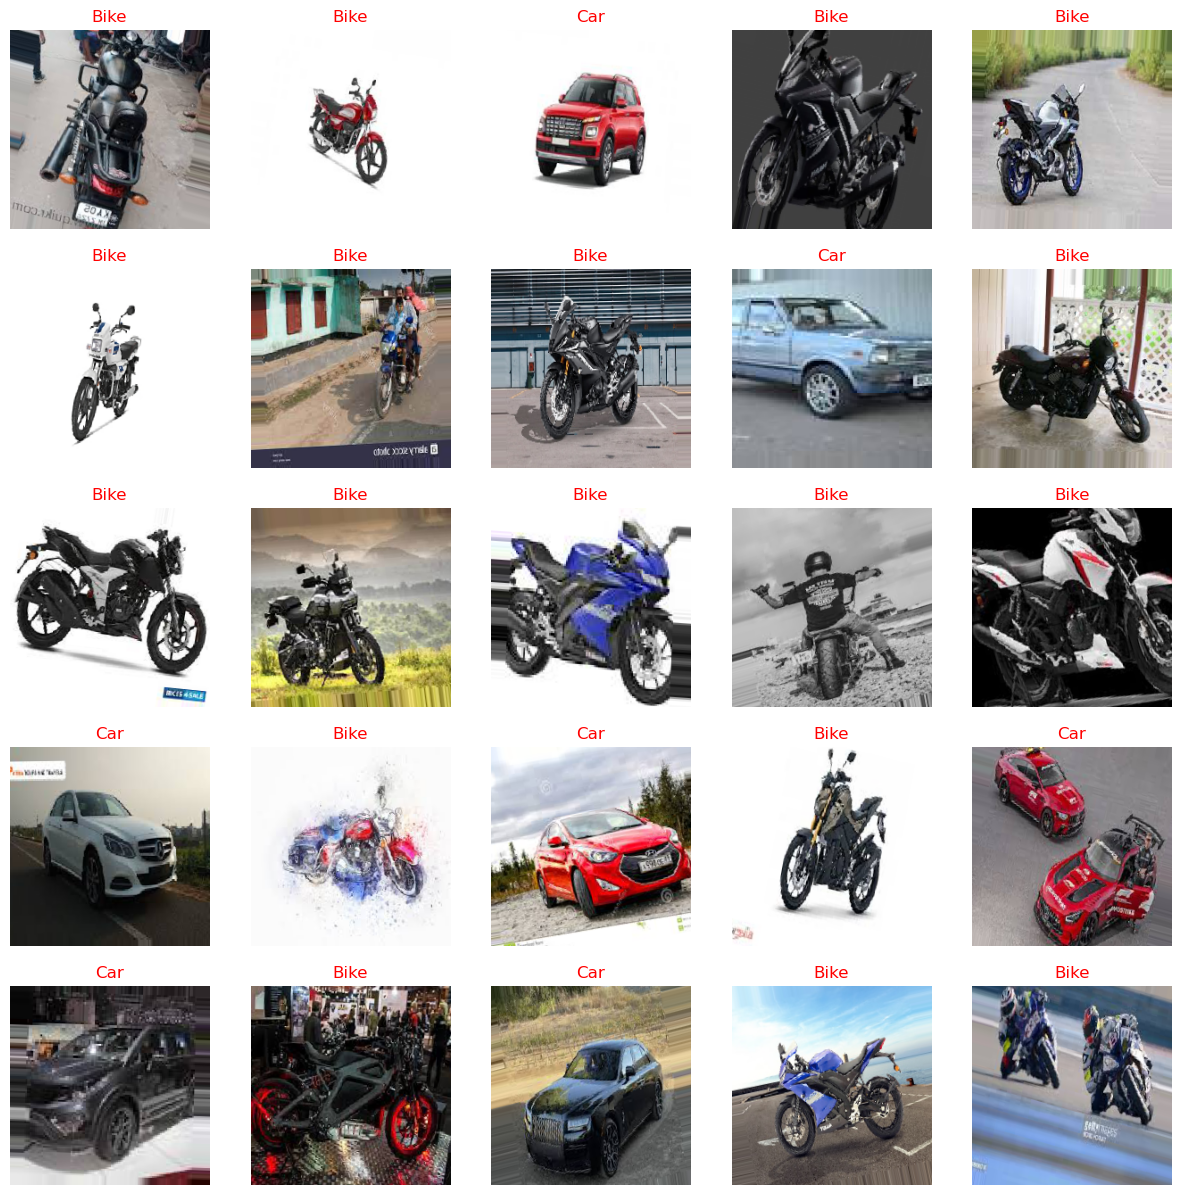

In [8]:
def show_images_samples(gen):
  map = gen.class_indices
  classes = list(map.keys())
  images, labels = next(gen)
  plt.figure(figsize=(15, 15))
  length = len(labels)
  for i in range(25):
    plt.subplot(5, 5, i + 1)
    image = images[i]
    plt.imshow(image)
    plt.axis('off')
    index = np.argmax(labels[i])
    class_name = classes[index]
    plt.title(class_name, color='red')
  plt.show()
show_images_samples(train_data)

In [12]:
class AlexNet:
  def __init__(self):
    self.model = None
    self.hist = None
  def build(self):
    model = tf.keras.Sequential()
    input = Input(shape=(224, 224, 3))
    model.add(input)
    model.add(Conv2D(96, kernel_size=(11, 11), strides=4, padding='valid', activation='relu'))
    model.add(MaxPool2D(pool_size=(3,3), strides=2, padding='valid'))
    model.add(Conv2D(256, kernel_size=(5, 5), strides=1, padding='same', activation='relu'))
    model.add(MaxPool2D(pool_size=(3,3), strides=2, padding='valid'))
    model.add(Conv2D(384, kernel_size=(3, 3), strides=1, padding='same', activation='relu'))
    model.add(Conv2D(384, kernel_size=(3, 3), strides=1, padding='same', activation='relu'))
    model.add(Conv2D(256, kernel_size=(3, 3), strides=1, padding='same', activation='relu'))
    model.add(MaxPool2D(pool_size=(3,3), strides=2, padding='valid'))
    model.add(Flatten())
    model.add(Dense(4096, activation=None))
    model.add(Dense(1024, activation='relu'))
    model.add(Dense(512, activation='relu'))
    model.add(Dense(2, activation='softmax'))
    self.model = model
  def train(self, train_data, val_data):
    self.model.compile(SGD(learning_rate=0.1), loss='categorical_crossentropy', metrics=['accuracy'])
    self.hist = self.model.fit(train_data, epochs=10, validation_data=val_data)
    
  def feature_extract(self, data):
    feature_extractor = tf.keras.Model(inputs=self.model.inputs, outputs=self.model.layers[-5].output)
    return feature_extractor.predict(data)
  def predict(self, test_data):
    return self.model.predict(test_data)
  def evaluate(self, test_data):
    acc = self.model.evaluate(test_data)
    print('acc: ', acc)
  def summary(self):
    return self.model.summary()
  def plot_acc(self):
    plt.plot(self.hist.history['accuracy'])
    plt.plot(self.hist.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
  def plot_loss(self):
    plt.plot(self.hist.history['loss'])
    plt.plot(self.hist.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
  def load(self, path):
    self.model = load_model(path)
  def save(self, path):
    self.model.save(path)

In [13]:
model = AlexNet()
model.build()
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 54, 54, 96)        34944     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 26, 26, 96)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 26, 26, 256)       614656    
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 12, 12, 256)      0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 12, 12, 384)       885120    
                                                                 
 conv2d_8 (Conv2D)           (None, 12, 12, 384)      

In [14]:
model.train(train_data, val_data)

Epoch 1/10
100/100 [==============================] - 49s 474ms/step - loss: 0.6874 - accuracy: 0.5416 - val_loss: 0.7039 - val_accuracy: 0.5000
Epoch 2/10
100/100 [==============================] - 47s 472ms/step - loss: 0.6802 - accuracy: 0.5897 - val_loss: 0.6912 - val_accuracy: 0.5000
Epoch 3/10
100/100 [==============================] - 46s 458ms/step - loss: 0.6918 - accuracy: 0.5434 - val_loss: 0.6354 - val_accuracy: 0.7200
Epoch 4/10
100/100 [==============================] - 46s 458ms/step - loss: 0.6444 - accuracy: 0.6450 - val_loss: 0.6463 - val_accuracy: 0.6650
Epoch 5/10
100/100 [==============================] - 47s 472ms/step - loss: 0.5623 - accuracy: 0.7191 - val_loss: 0.5081 - val_accuracy: 0.7850
Epoch 6/10
100/100 [==============================] - 48s 481ms/step - loss: 0.4408 - accuracy: 0.7981 - val_loss: 0.4476 - val_accuracy: 0.7950
Epoch 7/10
100/100 [==============================] - 47s 466ms/step - loss: 0.3809 - accuracy: 0.8259 - val_loss: 0.3613 - val_ac

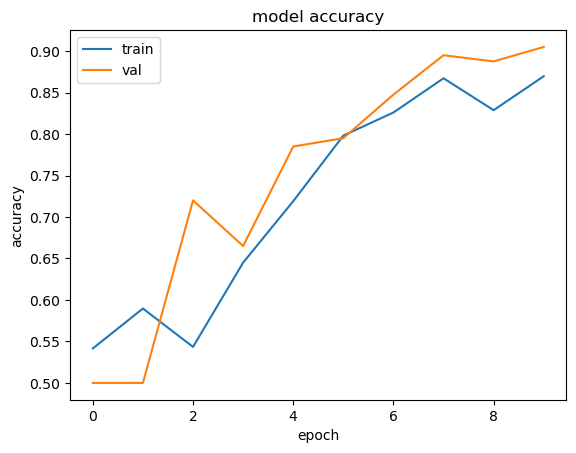

In [15]:
model.plot_acc()

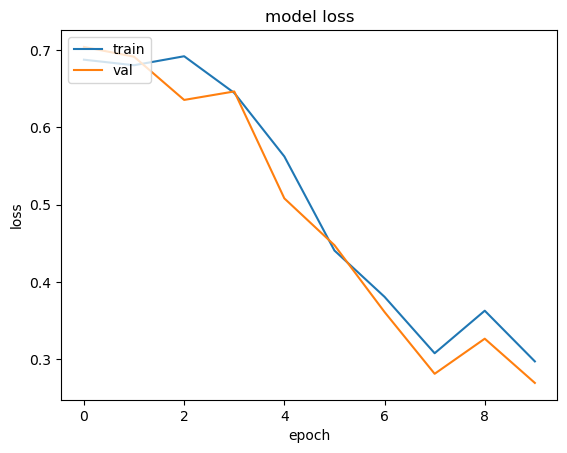

In [16]:
model.plot_loss()

In [17]:
vectors = model.feature_extract(test_data)

400/400 [==============================] - 2s 4ms/step


In [18]:
X_train, X_test, y_train, y_test = train_test_split(vectors, test_data.labels, test_size=0.2, random_state=42)

In [19]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [20]:
svc = SVC()
svc.fit(X_train, y_train)

SVC()

In [21]:
y_pred = svc.predict(X_test)

In [22]:
target = ['Car', 'Bike']
print(classification_report(y_test, y_pred, target_names=target))

              precision    recall  f1-score   support

         Car       0.93      0.93      0.93        44
        Bike       0.92      0.92      0.92        36

    accuracy                           0.93        80
   macro avg       0.92      0.92      0.92        80
weighted avg       0.93      0.93      0.93        80



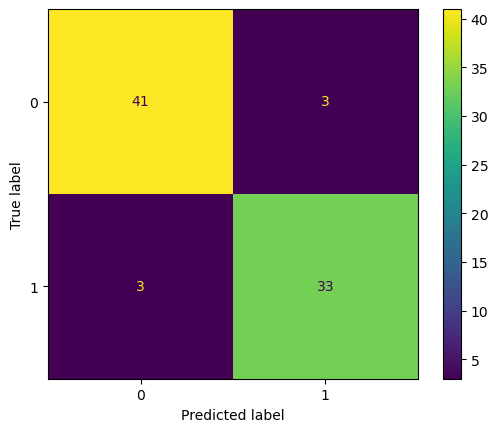

In [23]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()